In [167]:
import geojson
import numpy as np
from pandas_geojson import read_geojson
from pyproj import Transformer, Geod
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [ ]:
def smoke_effect(distance, acres):
  return np.exp(-distance + acres)*acres

def normalize_list(input_list):
  min_val = min(input_list)
  max_val = max(input_list)

  
  # Apply min-max scaling to each element of the list
  normalized_list = [(x - min_val) / (max_val - min_val) for x in input_list]
  
  return normalized_list

In [3]:
f = './GeoJSON_Exports/fires.json'
with open(f) as f:
    gj = geojson.load(f)


In [6]:
df = pd.DataFrame(gj)
df['d_norm'] = normalize_list(df['Distance'].tolist())
df['a_nrom'] = normalize_list(df['GIS_Acres'].tolist())

df['smoke_impact'] = df.apply(lambda row: smoke_effect(row['d_norm'], row['a_nrom']), axis=1)
df.head()

,USGS_Assigned_ID,Fire_Year,Assigned_Fire_Type,GIS_Acres,GIS_Hectares,Distance
0,14600,1964,Wildfire,65338.877636,26441.705659,845.776738
1,14601,1964,Wildfire,55960.694158,22646.489455,619.344908
2,14602,1964,Wildfire,19218.105903,7777.291530,854.021782
3,14603,1964,Wildfire,18712.494746,7572.677954,508.513915
4,14604,1964,Wildfire,16887.001024,6833.926855,567.056005


In [8]:
grouped_df = df.groupby('Fire_Year')[['smoke_impact', 'GIS_Acres']].sum().reset_index()
grouped_df.head()

,Fire_Year,smoke_impact,GIS_Acres
37,2001,1.800251,2.513526e+06
38,2002,3.047874,4.389436e+06
39,2003,2.557216,3.846964e+06
40,2004,0.769084,1.300962e+06
41,2005,2.802236,4.127114e+06
42,2006,5.336159,7.531362e+06
43,2007,6.532653,7.563110e+06
44,2008,2.164345,3.383959e+06
45,2009,1.295173,2.259960e+06
46,2010,1.362505,1.899260e+06


In [160]:
f_aqi = 'aqi_10_worst_avg_2002-2020.json'
with open(f_aqi, 'r') as json_file:
    aqi_data = json.load(json_file)
    aqi_data = {int(key): value for key, value in aqi_data.items()}
aqi_series = pd.Series(aqi_data, name='aqi')

df_aqi = grouped_df.copy()
df_aqi['aqi'] = grouped_df['Fire_Year'].map(aqi_series)
pd.concat([df, aqi_series], axis=1)

subset = df_aqi[df_aqi['Fire_Year'] > 2002] # AQI data in pullman not good until 2002
correlation = df_aqi['smoke_impact'].corr(df_aqi['aqi'])

print(f"Correlation between smoke impact and aqi: {correlation}")

Correlation between smoke impact and aqi: 0.7088189847835725


In [181]:
k = 12
X = []
y = []
observations = df_aqi['smoke_impact'].tolist()
labels = df_aqi['smoke_impact'].tolist()

for i in range(k, len(observations)):
    x_entry = []
    for j in range(i-k,i):
        x_entry.append(observations[j])
    X.append(x_entry)
    y.append(labels[i])

X = np.array(X)
y = np.array(y)

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

y_pred = model.predict(X)

mse = mean_squared_error(y, y_pred)

print(f"Mean Squared Error (MSE): {mse}")


Mean Squared Error (MSE): 1.7783727357636714


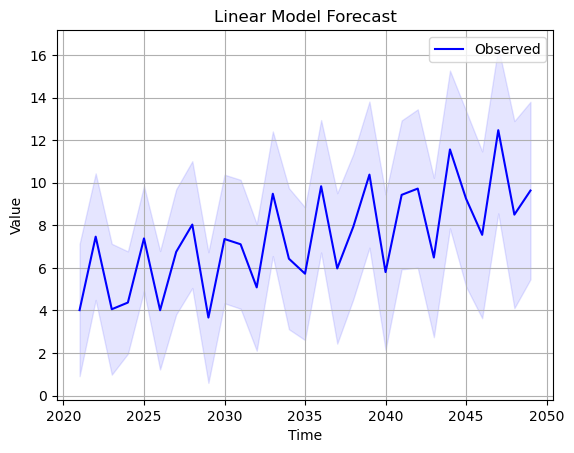

In [182]:
predictions = []
lower_bound = []
upper_bound = []
X_future = X.copy()
# print(len(X_future[-1]))
X_future = [1] + X[-1,2:].tolist() + [y_pred[-1]]
# print([1]+list(list(X_future[-2,1:]) + list(y_pred)[-1])
for i in range(29):
    X_future = [1] + X_future[2:] + [y_pred[-1]]
    y_pred = model.predict(X_future)
    confidence_interval = model.get_prediction(X_future).conf_int(alpha=0.05)

    l, u = confidence_interval[0]
    lower_bound.append(l)
    upper_bound.append(u)

    predictions.append(y_pred[-1])

plt.plot([x for x in range(2021, 2021+29)], predictions, label='Observed', color='blue')
plt.fill_between([x for x in range(2021, 2021+29)], lower_bound, upper_bound, color='blue', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Linear Model Forecast')
plt.legend()
plt.grid(True)
plt.show()


In [178]:
p, d, q = 5, 1, 5 # Non-seasonal orders
P, D, Q, s = 5, 1, 5, 10  # Seasonal orders

sarima_model = SARIMAX(df_aqi['smoke_impact'], order=(p,d,q), seasonal_order=(P, D, Q, s), method='nm')
sarima_results = sarima_model.fit()

/Users/chandlerault/opt/miniconda3/envs/ca/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['method']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/chandlerault/opt/miniconda3/envs/ca/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/chandlerault/opt/miniconda3/envs/ca/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/chandlerault/opt/miniconda3/envs/ca/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94028D+00    |proj g|=  3.68426D-01

At iterate    5    f=  1.53637D+00    |proj g|=  1.17949D-01

At iterate   10    f=  1.48444D+00    |proj g|=  1.03665D-01

At iterate   15    f=  1.45319D+00    |proj g|=  1.07804D-01

At iterate   20    f=  1.43190D+00    |proj g|=  1.02607D-01

At iterate   25    f=  1.42386D+00    |proj g|=  4.91268D-02

At iterate   30    f=  1.41906D+00    |proj g|=  5.61653D-02

At iterate   35    f=  1.41406D+00    |proj g|=  2.67269D-02

At iterate   40    f=  1.41314D+00    |proj g|=  1.48836D-02

At iterate   45    f=  1.40975D+00    |proj g|=  5.10320D-02


/Users/chandlerault/opt/miniconda3/envs/ca/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.40862D+00    |proj g|=  2.06045D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   21     50     55      1     0     0   2.060D-02   1.409D+00
  F =   1.4086236190379764     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


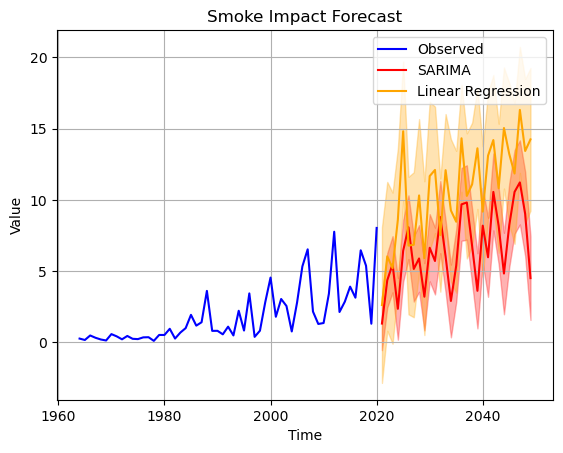

In [177]:

n = 29 # 2021 - 2049
forecast = sarima_results.get_forecast(steps=n) 
a = np.array([x for x in range(2021,2021+n)])
plt.plot(df_aqi['Fire_Year'], df_aqi['smoke_impact'], label='Observed', color='blue')
plt.plot(a, list(forecast.predicted_mean), label='SARIMA', color='red')
plt.fill_between(a, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='red', alpha=0.3)
plt.plot(a, predictions, label='Linear Regression', color='orange')
plt.fill_between(a, lower_bound, upper_bound, color='orange', alpha=0.3)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Smoke Impact Forecast')
plt.legend()
plt.grid(True)
plt.show()